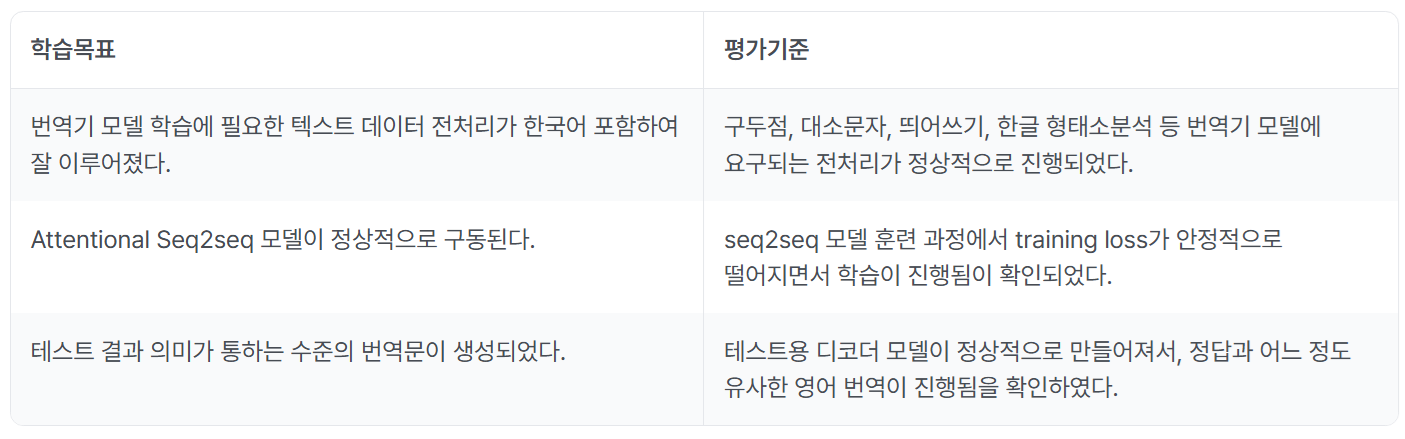

# **프로젝트 진행 개요**


1.   우선 노드 학습내용을 토대로 팀 베이스코드를 만듬 (sentencepiece 사용)
2.   이후 코드의 수정을 통해서 성능 개선작업을 수행하였음

# **성능 개선을 위한 주요 작업**
1.   Convext Vector가 제대로 구현될 수 있도록 체크 및 수정
2.   Dropout 추가
3.   과적합 방지를 위한 early-stop 부여

# **실험을 통한 성능 개선 결과**

어텐션 비교 - 기존

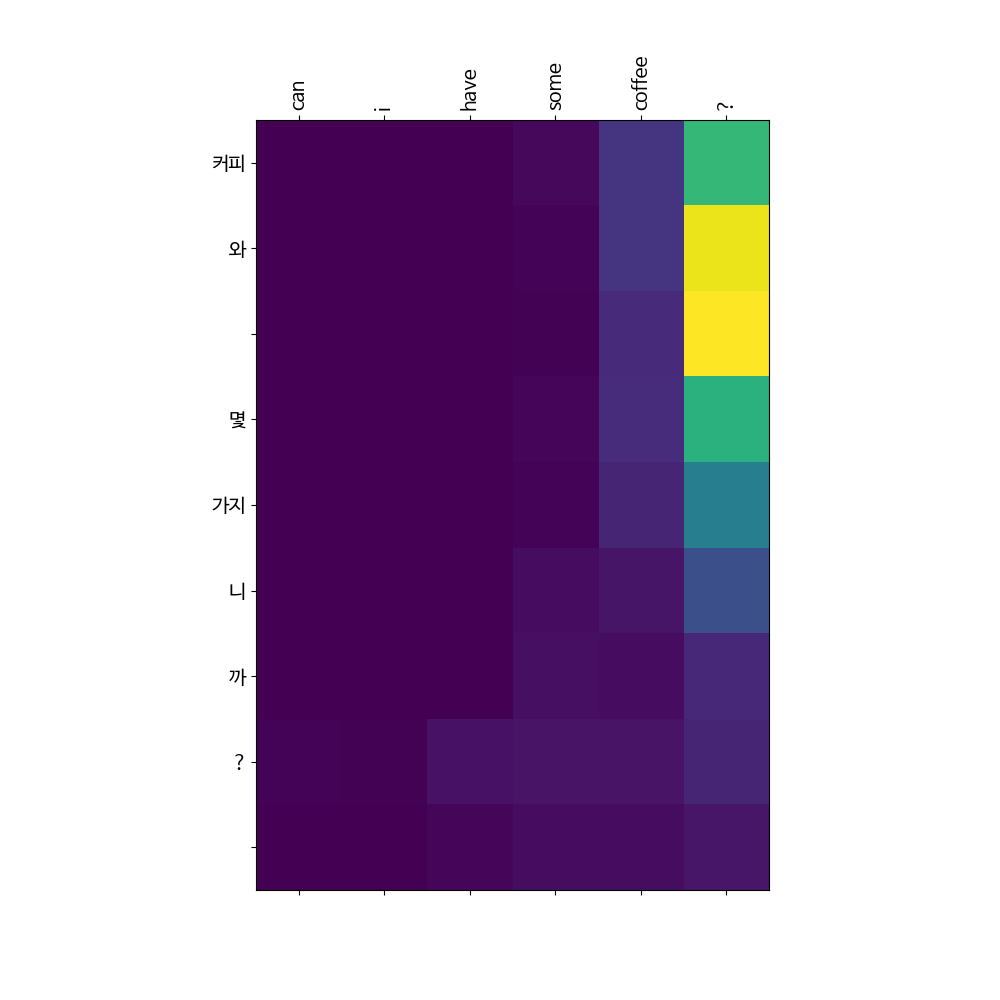

어텐션 비교 - 개선 후

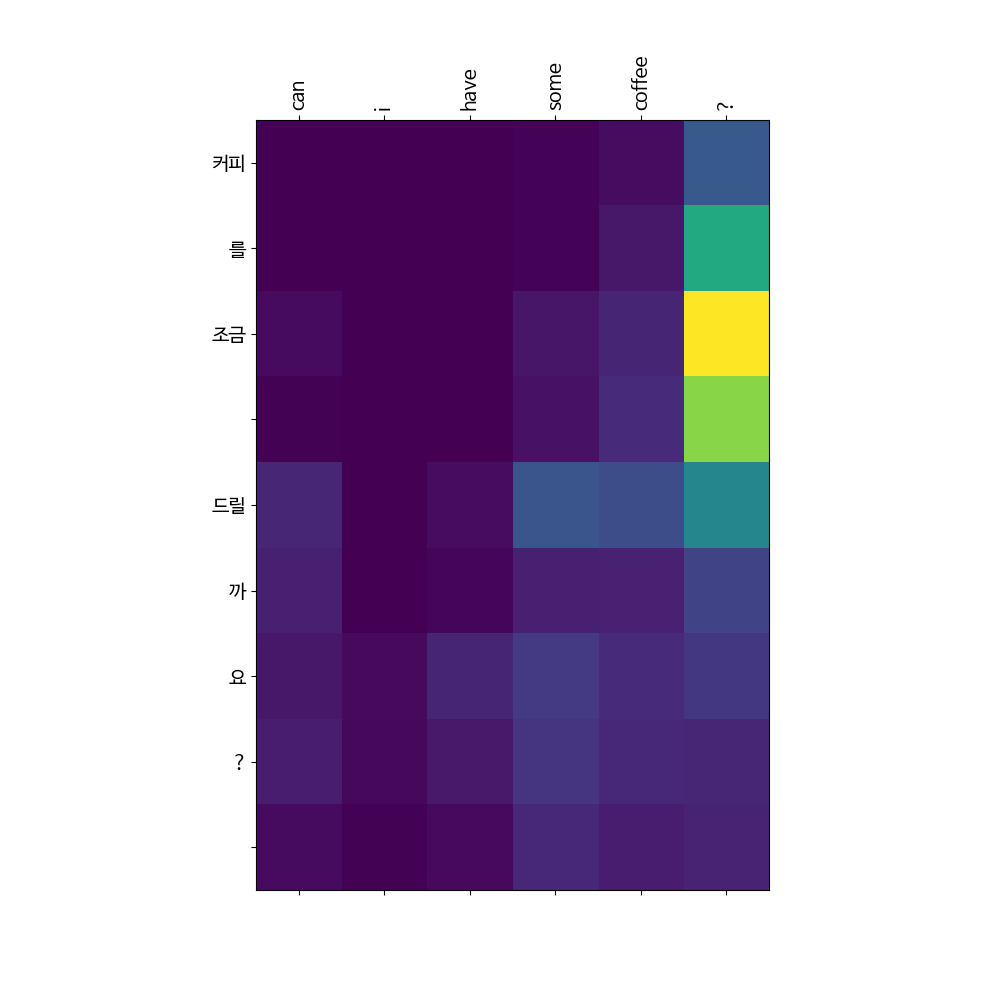

# **결과분석**
본질적으로 큰 개선이 이루어졌다고 보기 어려운 것 같다. 조금 더 비슷한 말을 생성하고 있으나, 어텐션 맵에서 분석을 해보면 개선이 아쉽다. . 추가적인 실험과 성능개선이 필요한 듯 하다.

아직 무엇을 어떻게 개선해야할 지 원인과 방안을 생각해보고 있다.

## **주요 하이퍼파라미터와 성능 지표 비교**

# **개선 전**

Best: epoch 11, train loss 1.33,	Train acc 0.68, Val loss	2.88, Val acc	0.49

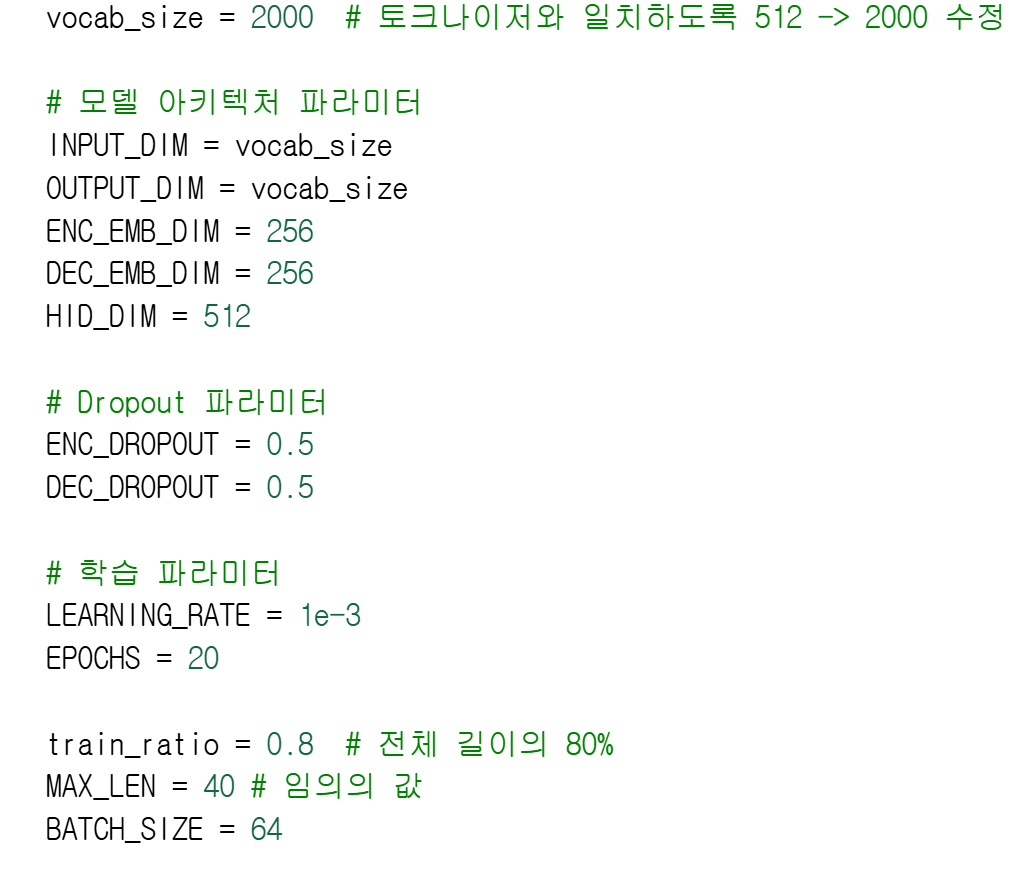

# **개선 후**

Best: epoch 7, train loss 1.86, Train acc 0.57, Val loss 2.98, Val acc 0.46

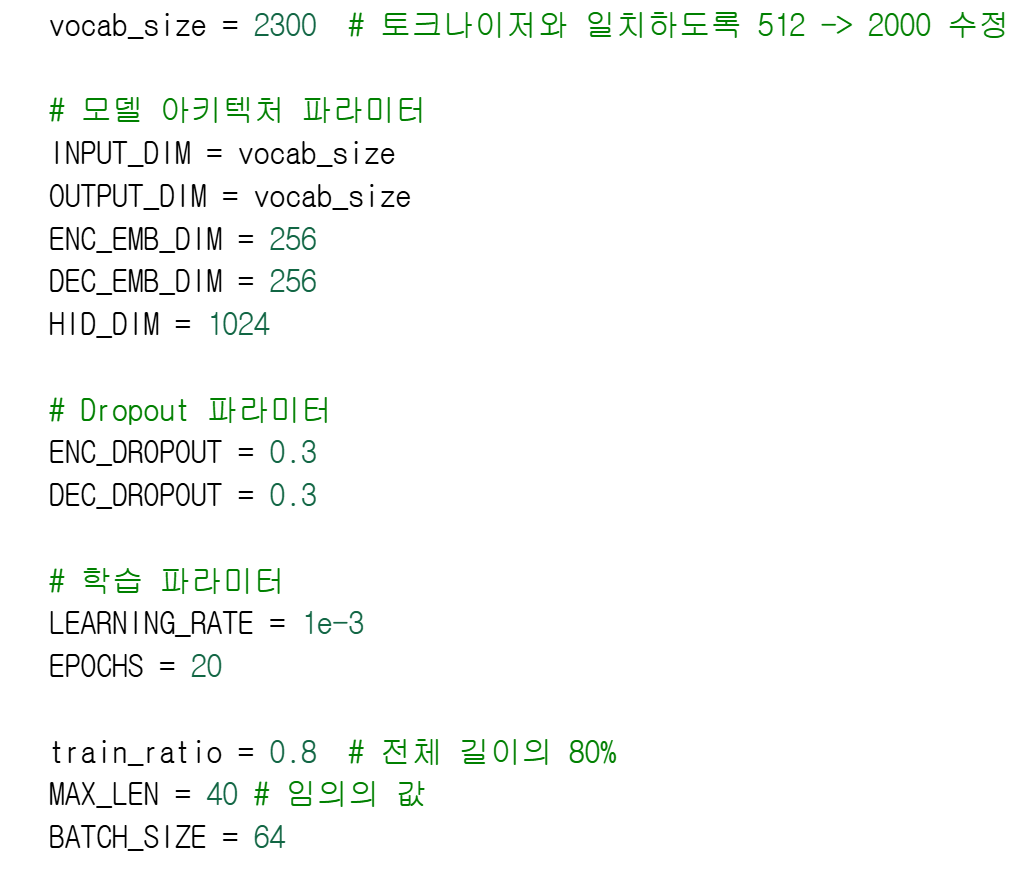

# **소회**

모델의 구조나 프로그램 언어 단에서 아직 모호하게 알고 있는 부분들이 꽤 있다. 그래서 어떤 부분에 문제가 있는지 아직은 잘 분석해내고 있지 못하고 있다. 조금더 분석적으로 개선 방안을 찾기위해서는 좀더 디테일한 학습과 이해가 필요할 듯하다.

중요하게 배운 점은 커널이 자꾸 다운되는 커널 패닉 현상에 대해서 배웠고 이를 대처하기 위한 방법을 알게되었다. 자원관리가 중요한 역량임을 알게되엇다.

# **1. 프로젝트 코드 환경셋팅**

In [ ]:
#관리자로 설치해야지 된다. 폰트 문제 해결을 배웠다.
!sudo apt update
!sudo apt install fonts-nanum

Hit:1 https://cli.github.com/packages stable InRelease
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [2,151 kB]
Get:6 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Get:9 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:11 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Hit:12 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:13 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu j

In [ ]:
#폰트 설치에 이어지는 블록, 은근 설치가 안될때가 있으므로 연습해봐야한다.
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib.ticker as ticker
import logging
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

logging.getLogger("matplotlib.font_manager").setLevel(logging.ERROR)

fontpath = "/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf"
fontprop = fm.FontProperties(fname=fontpath, size=12)
plt.rcParams["font.family"] = fontprop.get_name()

print(f"설정된 폰트: {fontprop.get_name()}")

설정된 폰트: NanumBarunGothic


In [ ]:
# 콘피도 까다롭다. 잘 셋팅해야한다.
!pip install konlpy
!pip install sentencepiece

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 106.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 495.9/495.9 kB 48.1 MB/s eta 0:00:00


In [ ]:
# 라이브러리 임포트
import os
import re
import urllib.request
import zipfile
import sentencepiece as spm
import pandas as pd

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset

from tqdm import tqdm
import random



# **2.데이터 받기 및 체크**

In [ ]:
# dataset_dir는 본인이 작업하고 있는 위치로 변경
dataset_dir = os.path.join(os.path.expanduser("/content/work/dataset"), "kor-eng")
os.makedirs(dataset_dir, exist_ok=True)
zip_path = os.path.join(dataset_dir, "kor-eng.zip")

if not os.path.exists(zip_path):
    print("데이터 다운로드 중...")
    url = "https://www.manythings.org/anki/kor-eng.zip"

    # Add a User-Agent header to mimic a web browser
    opener = urllib.request.build_opener()
    opener.addheaders = [('User-Agent', 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3')]
    urllib.request.install_opener(opener)

    urllib.request.urlretrieve(url, zip_path)
    print("다운로드 완료!")

# data_folder 변수를 제거하고 kor.txt의 경로를 직접 dataset_dir 아래로 설정
if not os.path.exists(os.path.join(dataset_dir, "kor.txt")):
    print("압축 해제 중...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(dataset_dir)
    print("압축 해제 완료!")

path_to_file = os.path.join(dataset_dir, "kor.txt")


데이터 다운로드 중...
다운로드 완료!
압축 해제 중...
압축 해제 완료!


In [ ]:
# attribute 제거하게 읽음
df = pd.read_csv(path_to_file, sep="\t", names=["eng", "kor", "attribute"])
df = df[['eng', 'kor']]  # attribute 컬럼 제외
display(df.head())  # display()를 사용하여 head() 결과가 항상 출력되도록 수정
print(df.shape)

,eng,kor
0,Go.,가.
1,Hi.,안녕.
2,Run!,뛰어!
3,Run.,뛰어.
4,Who?,누구?


(6381, 2)


# **3. 전처리, 토큰화 및 하이퍼파라미터 설정**

In [ ]:
# 전처리 함수 정의
def preprocess_text(text):
    """
    텍스트 전처리 함수
    """
    if pd.isna(text):
        return ""

    text = str(text)

    # 1. 소문자화
    text = text.lower()

    # 2. 반복되는 문장 부호 제거 (2개 이상 → 1개)
    text = re.sub(r'([.!?,])\1+', r'\1', text)

    # 3. 영어/숫자/한글/문장부호만 남기고 모두 삭제
    # 이모지, 이모티콘, 특수문자 자동 제거
    # ' -> 추가
    text = re.sub(r"[^가-힣a-zA-Z0-9\s.!?,']", " ", text)

    # 4. 문장부호 앞뒤로 공백 추가
    text = re.sub(r'([.!?,])', r' \1 ', text)

    # 5. 연속 공백을 하나의 공백으로 교체
    text = re.sub(r'\s+', ' ', text)

    # 6. 앞뒤 공백 제거
    text = text.strip()

    return text

In [55]:
# 전체 진행 - 노드처럼 30000개를 지정하려면 아래에 코드에서 # 제거 필요
#df = df[:30000]

df["eng"] = df["eng"].apply(preprocess_text)
df["kor"] = df["kor"].apply(lambda x:preprocess_text(x))

display(df.head())  # display()를 사용하여 head() 결과가 항상 출력되도록 수정
print(df.shape)

,eng,kor
0,go .,가 .
1,hi .,안녕 .
2,run !,뛰어 !
3,run .,뛰어 .
4,who ?,누구 ?


(6381, 2)


In [56]:
df["eng"].to_csv("eng_corpus.txt", index=False, header=False, sep="\n", encoding="utf-8")
df["kor"].to_csv("kor_corpus.txt", index=False, header=False, sep="\n", encoding="utf-8")

print("파일 저장 완료: eng_corpus.txt, kor_corpus.txt")

파일 저장 완료: eng_corpus.txt, kor_corpus.txt


토큰화 후 적정 커버리지 분석하였으며, 여러가지 실험을 위하여 0.98 이상의 coverage를 선택하였음. 해당 부분의 코딩과 분석 작업은 길어지므로 포함시키지 않았음.

In [59]:
# 코드 구조상 하이퍼파라미터를 이곳에서 종합하게 되었음
# ============================================================================
# 주요 하이퍼파라미터 설정 (통합)
# ============================================================================

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vocab_size = 2300  # 토크나이저와 일치하도록 512 -> 2000 수정

# 모델 아키텍처 파라미터
INPUT_DIM = vocab_size
OUTPUT_DIM = vocab_size
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 1024

# Dropout 파라미터
ENC_DROPOUT = 0.3
DEC_DROPOUT = 0.3

# 학습 파라미터
LEARNING_RATE = 1e-3
EPOCHS = 20

train_ratio = 0.8  # 전체 길이의 80%
MAX_LEN = 40 # 임의의 값
BATCH_SIZE = 64

In [60]:
#토크나이저 sentencepiece 사용
vocab_size = vocab_size  # 512는 너무 작으므로 2000으로 변경
pad_id = 0
bos_id = 1
eos_id = 2
unk_id = 3

spm.SentencePieceTrainer.train(
    input = "eng_corpus.txt",
    model_prefix = "encoder_spm",
    vocab_size = vocab_size,
    character_coverage=1.0, # 오류 수정: 0.85 -> 1.0 (최소 0.98 이상 요구됨)
    pad_id = pad_id,
    bos_id = bos_id,
    eos_id = eos_id,
    unk_id = unk_id
)

spm.SentencePieceTrainer.train(
    input = "kor_corpus.txt",
    model_prefix = "decoder_spm",
    vocab_size = vocab_size,
    character_coverage=1.0, # 오류 수정: 0.85 -> 1.0
    pad_id = pad_id,
    bos_id = bos_id,
    eos_id = eos_id,
    unk_id = unk_id
)

In [61]:
encoder_tokenizer = spm.SentencePieceProcessor()
encoder_tokenizer.load("encoder_spm.model")

decoder_tokenizer = spm.SentencePieceProcessor()
decoder_tokenizer.load("decoder_spm.model")

True

In [62]:
df

,eng,kor
0,go .,가 .
1,hi .,안녕 .
2,run !,뛰어 !
3,run .,뛰어 .
4,who ?,누구 ?
...,...,...
6376,i started a new blog . i'll do my best not to ...,난 블로그를 시작했어 . 블로그를 초반에만 반짝 많이 하다가 관두는 사람처럼은 되지...
6377,i think it's a shame that some foreign languag...,몇몇 외국어 선생님이 한 번도 원어민과 공부해본 적도 없으면서 대학을 나올 수 있었...
6378,and the good news is that today the economy is...,"다음으로 좋은 소식은 오늘 경제가 재성장한다는 것입니다 . 임금 , 소득 , 집값 ..."
6379,if someone who doesn't know your background sa...,만일 네 사정도 잘 모르는 사람이 원어민 같다고 말한다면 그건 그 사람이 네가 원어...


In [63]:
eng_sample = df["eng"][6380]
kor_sample = df["kor"][6380]
print(eng_sample)
print(kor_sample)

doubtless there exists in this world precisely the right woman for any given man to marry and vice versa but when you consider that a human being has the opportunity of being acquainted with only a few hundred people , and out of the few hundred that there are but a dozen or less whom he knows intimately , and out of the dozen , one or two friends at most , it will easily be seen , when we remember the number of millions who inhabit this world , that probably , since the earth was created , the right man has never yet met the right woman .
의심의 여지 없이 세상에는 어떤 남자이든 정확히 딱 알맞는 여자와 결혼하거나 그 반대의 상황이 존재하지 . 그런데 인간이 수백 명의 사람만 알고 지내는 사이가 될 기회를 갖는다고 생각해 보면 , 또 그 수백 명 중 열여 명 쯤 이하만 잘 알 수 있고 , 그리고 나서 그 열여 명 중에 한두 명만 친구가 될 수 있다면 , 그리고 또 만일 우리가 이 세상에 살고 있는 수백만 명의 사람들만 기억하고 있다면 , 딱 맞는 남자는 지구가 생겨난 이래로 딱 맞는 여자를 단 한번도 만난 적이 없을 수도 있을 거라는 사실을 쉽게 눈치챌 수 있을 거야 .


In [64]:
enc_token = encoder_tokenizer.encode(eng_sample)
enc_token = [encoder_tokenizer.bos_id()] + enc_token + [encoder_tokenizer.eos_id()]
enc_token

[1,
 1230,
 570,
 54,
 732,
 6,
 27,
 43,
 6,
 238,
 134,
 1750,
 136,
 40,
 15,
 8,
 171,
 127,
 742,
 51,
 73,
 222,
 19,
 124,
 10,
 1509,
 21,
 8,
 72,
 513,
 135,
 1256,
 6,
 87,
 151,
 109,
 11,
 1382,
 20,
 13,
 307,
 440,
 64,
 15,
 575,
 1537,
 1262,
 21,
 34,
 440,
 957,
 2008,
 279,
 367,
 60,
 57,
 40,
 13,
 123,
 350,
 994,
 177,
 8,
 29,
 8,
 72,
 128,
 34,
 15,
 123,
 350,
 994,
 20,
 54,
 38,
 151,
 13,
 1171,
 19,
 261,
 838,
 75,
 25,
 28,
 47,
 6,
 27,
 12,
 1981,
 40,
 8,
 29,
 8,
 72,
 128,
 34,
 15,
 1171,
 19,
 8,
 29,
 113,
 261,
 68,
 296,
 305,
 69,
 328,
 8,
 29,
 30,
 98,
 8,
 1221,
 40,
 26,
 155,
 19,
 8,
 29,
 109,
 36,
 308,
 15,
 874,
 34,
 1659,
 6,
 75,
 1742,
 780,
 43,
 6,
 238,
 134,
 8,
 29,
 20,
 609,
 722,
 21,
 8,
 29,
 668,
 15,
 653,
 207,
 31,
 1436,
 18,
 8,
 29,
 15,
 8,
 171,
 124,
 64,
 137,
 247,
 12,
 398,
 15,
 8,
 171,
 127,
 742,
 4,
 2]

In [65]:
enc_decoding = encoder_tokenizer.decode(enc_token)
enc_decoding

'doubtless there exists in this world precisely the right woman for any given man to marry and vice versa but when you consider that a human being has the opportunity of being acquainted with only a few hundred people , and out of the few hundred that there are but a dozen or less whom he knows intimately , and out of the dozen , one or two friends at most , it will easily be seen , when we remember the number of millions who inhabit this world , that probably , since the earth was created , the right man has never yet met the right woman .'

# **4. Dataloader, attention, 모델 설정**

In [66]:
class TranslationDataset(Dataset):
    def __init__(self, data, encoder_tokenizer, decoder_tokenizer, max_len):
        self.data = data
        self.encoder_tokenizer = encoder_tokenizer
        self.decoder_tokenizer = decoder_tokenizer
        self.max_len = max_len
        self.pad_id = 0
        self.bos_id = 1
        self.eos_id = 2

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        src_text = self.data.iloc[idx]['eng']
        trg_text = self.data.iloc[idx]['kor']

        src_ids = self.encoder_tokenizer.encode(src_text)
        trg_ids = self.decoder_tokenizer.encode(trg_text)

        src_ids = src_ids[:self.max_len]

        # Decoder의 입력에는 START_TOKEN과 END_TOKEN을 추가해줍니다. 단, 최대 길이 제한을 적용시킵니다.
        trg_input = [self.bos_id] + trg_ids[:self.max_len - 2] + [self.eos_id]
        trg_label = trg_ids[:self.max_len - 1] + [self.eos_id]

        # 길이가 짧은 경우 PAD_TOKEN을 추가해줍니다.
        src_ids = src_ids + [self.pad_id] * (self.max_len - len(src_ids))
        trg_input = trg_input + [self.pad_id] * (self.max_len - len(trg_input))
        trg_label = trg_label + [self.pad_id] * (self.max_len - len(trg_label))

        return torch.tensor(src_ids), torch.tensor(trg_input), torch.tensor(trg_label)

In [67]:

train_data = df.sample(frac=train_ratio, random_state=42)  # 80% 훈련 데이터
valid_data = df.drop(train_data.index)

train_data.reset_index(drop=True, inplace=True)
valid_data.reset_index(drop=True, inplace=True)

train_data = TranslationDataset(train_data, encoder_tokenizer, decoder_tokenizer, max_len=MAX_LEN)
validataion_data = TranslationDataset(valid_data, encoder_tokenizer, decoder_tokenizer, max_len=MAX_LEN)

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
validation_loader = DataLoader(validataion_data, batch_size=BATCH_SIZE, shuffle=False)

In [68]:
for src, trg_input, trg_label in train_loader:
    print(src.shape, trg_input.shape, trg_label.shape)
    break

torch.Size([64, 40]) torch.Size([64, 40]) torch.Size([64, 40])


In [69]:
class BahdanauAttention(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()

        self.W1 = nn.Linear(hidden_dim, hidden_dim)
        self.W2 = nn.Linear(hidden_dim, hidden_dim)
        self.v = nn.Linear(hidden_dim, 1, bias=False)

    def forward(self, hidden, encoder_outputs):
        # hidden: (batch_size, hidden_dim)
        # encoder_outputs: (src_len, batch_size, hidden_dim)

        src_len = encoder_outputs.shape[0]

        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)  # (batch_size, src_len, hidden_dim)
        encoder_outputs = encoder_outputs.permute(1, 0, 2)  # (batch_size, src_len, hidden_dim)

        energy = torch.tanh(self.W1(encoder_outputs) + self.W2(hidden))  # (batch_size, src_len, hidden_dim)
        attention = self.v(energy).squeeze(2)  # (batch_size, src_len)

        return nn.functional.softmax(attention, dim=1)  # (batch_size, src_len)

In [70]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hidden_dim, dropout):
        super().__init__()

        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.dropout = nn.Dropout(dropout)
        self.rnn = nn.GRU(emb_dim, hidden_dim, dropout=dropout)

    def forward(self, src):
        # src : (src_len, batch_size)
        embedded = self.embedding(src)  # embedded : (src_len, batch_size, emb_dim)
        embedded = self.dropout(embedded)  # Dropout 적용
        outputs, hidden = self.rnn(embedded)  # outputs : (src_len, batch_size, hidden_dim)

        return outputs, hidden

In [71]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hidden_dim, attention, dropout):
        super(Decoder, self).__init__()

        self.output_dim = output_dim
        self.attention = attention
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.dropout = nn.Dropout(dropout)
        # Decoder RNN: embedding + attention context
        self.rnn = nn.GRU(emb_dim + hidden_dim, hidden_dim, dropout=dropout)
        # 출력층: hidden state + attention value
        self.fc_out = nn.Linear(hidden_dim + hidden_dim, output_dim)

    def forward(self, input, hidden, encoder_outputs):
        input = input.unsqueeze(0) # (1, batch)
        embedded = self.embedding(input)
        embedded = self.dropout(embedded) # (1, batch, emb_dim)

        # GRU hidden: (num_layers, batch, hidden) -> (batch, hidden) (마지막 레이어 사용)
        attention = self.attention(hidden[-1], encoder_outputs) # (batch, src_len)

        attention = attention.unsqueeze(1) # (batch, 1, src_len)
        encoder_outputs = encoder_outputs.permute(1, 0, 2) # (batch, src_len, hidden)

        # (batch, 1, src_len) x (batch, src_len, hidden) -> (batch, 1, hidden)
        attention_applied = torch.bmm(attention, encoder_outputs)

        attention_applied = attention_applied.permute(1, 0, 2) # (1, batch, hidden)

        # 이제 embedded와 차원이 (1, batch, ...)로 일치하므로 연결 가능
        rnn_input = torch.cat([embedded, attention_applied], dim=2)
        output, hidden = self.rnn(rnn_input, hidden)

        rnn_output = output.squeeze(0) # (batch, hidden)
        attention_applied = attention_applied.squeeze(0) # (batch, hidden)

        prediction = self.fc_out(torch.cat([rnn_output, attention_applied], dim=1))

        return prediction, hidden, attention.squeeze(1) # attention 리턴 시 차원 복구

In [72]:
class Seq2SeqAttention(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, trg=None, max_len=40, bos_id = 1, eos_id=2):
        # 학습 모드에서는 trg_len 사용, 추론 모드에서는 max_len까지 동적 생성
        batch_size = src.shape[1]
        trg_vocab_size = self.decoder.fc_out.out_features

        # 조기 종료를 위해 tensor가 아닌 리스트 사용
        outputs = []

        # 시각화를 위해 attention 저장
        attentions = []

        # 인코더를 통해 context 생성
        encoder_outputs, hidden = self.encoder(src)

        if trg is not None:
            for t in range(0, trg.shape[0]):
                input = trg[t]
                output, hidden, attention = self.decoder(input, hidden, encoder_outputs)
                outputs.append(output.unsqueeze(0))
                attentions.append(attention.unsqueeze(0))

        else:
		    # inference에서는 target(정답)이 없기 때문에 sos_token을 생성해줍니다.
            input = torch.full((batch_size,), bos_id, dtype=torch.long, device=self.device)
            finished = torch.zeros(batch_size, dtype=torch.bool, device=self.device)

            for t in range(max_len):
                output, hidden, attention = self.decoder(input, hidden,  encoder_outputs)
                outputs.append(output.unsqueeze(0))
                attentions.append(attention.unsqueeze(0))
                top1 = output.argmax(1)
                input = top1

                # 조기 종료 조건
                finished |= (top1 == eos_id)
                if finished.all():
                    break

        outputs = torch.cat(outputs, dim=0)  # (trg_len, batch_size, output_dim)
        attentions = torch.cat(attentions, dim=0)  # (trg_len, batch_size, src_len)

        return outputs, attentions

In [73]:
encoder = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, ENC_DROPOUT).to(device)
attention = BahdanauAttention(HID_DIM).to(device)
decoder = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, attention, DEC_DROPOUT).to(device)

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


In [74]:
model = Seq2SeqAttention(encoder, decoder, device).to(device)
print(model)

Seq2SeqAttention(
  (encoder): Encoder(
    (embedding): Embedding(2300, 256)
    (dropout): Dropout(p=0.3, inplace=False)
    (rnn): GRU(256, 1024, dropout=0.3)
  )
  (decoder): Decoder(
    (attention): BahdanauAttention(
      (W1): Linear(in_features=1024, out_features=1024, bias=True)
      (W2): Linear(in_features=1024, out_features=1024, bias=True)
      (v): Linear(in_features=1024, out_features=1, bias=False)
    )
    (embedding): Embedding(2300, 256)
    (dropout): Dropout(p=0.3, inplace=False)
    (rnn): GRU(1280, 1024, dropout=0.3)
    (fc_out): Linear(in_features=2048, out_features=2300, bias=True)
  )
)


# **5. 학습함수,  손실함수, 성능 평가함수 정의**

In [75]:
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss(ignore_index=pad_id)

print("슝~")

슝~


In [76]:
def train_step(model, data_loader, optimizer, criterion, epoch):
    model.train()
    epoch_loss = 0
    epoch_acc = 0
    total_tokens = 0

    progress_bar = tqdm(data_loader, desc=f"Epoch {epoch+1}", leave=True)

    for src, trg_input, trg_label in progress_bar:
        src, trg_input, trg_label = src.to(device), trg_input.to(device), trg_label.to(device)

        src = src.transpose(0, 1)
        trg_input = trg_input.transpose(0, 1)
        trg_label = trg_label.transpose(0, 1)

        optimizer.zero_grad()

        outputs, _ = model(src, trg_input)

        # Reshape
        output_dim = outputs.shape[-1]
        outputs_flatten = outputs.view(-1, output_dim)
        trg_label_flatten = trg_label.reshape(-1)

        loss = criterion(outputs_flatten, trg_label_flatten)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)

        optimizer.step()

        epoch_loss += loss.item()

        # 정확도 계산 (Padding 제외)
        prediction = outputs_flatten.argmax(1)
        mask = trg_label_flatten != pad_id
        correct = (prediction[mask] == trg_label_flatten[mask]).sum().item()
        total = mask.sum().item()

        epoch_acc += correct
        total_tokens += total

        progress_bar.set_postfix(loss=loss.item(), acc=correct/total if total > 0 else 0)

    return epoch_loss / len(data_loader), epoch_acc / total_tokens if total_tokens > 0 else 0

print("train_step 수정 완료")

train_step 수정 완료


In [77]:
def eval_step(model, data_loader, optimizer, criterion):
    model.eval()
    total_loss = 0
    total_acc = 0
    total_tokens = 0

    with torch.no_grad():
        for src, trg_input, trg_label in data_loader:
            src, trg_input, trg_label = src.to(device), trg_input.to(device), trg_label.to(device)

            src = src.transpose(0, 1)
            trg_input = trg_input.transpose(0, 1)
            trg_label = trg_label.transpose(0, 1)

            outputs, _ = model(src, trg_input)

            outputs_flatten = outputs.view(-1, outputs.shape[-1])
            trg_label_flatten = trg_label.reshape(-1)

            loss = criterion(outputs_flatten, trg_label_flatten)
            total_loss += loss.item()

            # 정확도 계산
            prediction = outputs_flatten.argmax(1)
            mask = trg_label_flatten != pad_id
            correct = (prediction[mask] == trg_label_flatten[mask]).sum().item()
            total = mask.sum().item()

            total_acc += correct
            total_tokens += total

    return total_loss / len(data_loader), total_acc / total_tokens if total_tokens > 0 else 0

print("eval_step 수정 완료")

eval_step 수정 완료


# **6. 학습 및 번역기 함수 정의**

In [78]:
%%time

training_history = []

best_valid_loss = float('inf')
patience = 3
counter = 0
best_model_state = None

# CSV 파일 경로 설정
history_path = os.path.join(dataset_dir, 'training_history.csv')

for epoch in range(EPOCHS):
    train_loss, train_acc = train_step(model, train_loader, optimizer, criterion, epoch)
    valid_loss, valid_acc = eval_step(model, validation_loader, optimizer, criterion)

    print(f'Epoch {epoch+1}/{EPOCHS}')
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
    print(f'Valid Loss: {valid_loss:.4f}, Valid Acc: {valid_acc:.4f}')

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        counter = 0
        best_model_state = model.state_dict()
        torch.save(best_model_state, os.path.join(dataset_dir, 'best_model.pt'))
        print(f'Validation loss improved! Saving model to {dataset_dir}/best_model.pt')
    else:
        counter += 1
        print(f'Validation loss did not improve for {counter} epochs.')

    training_history.append({
        'epoch': epoch + 1,
        'train_loss': train_loss,
        'train_acc': train_acc,
        'valid_loss': valid_loss,
        'valid_acc': valid_acc
    })

    # 매 에포크마다 이력 저장 (덮어쓰기)
    pd.DataFrame(training_history).to_csv(history_path, index=False)
    print(f'Training history saved to {history_path}')

    if counter >= patience:
        print(f'Early stopping triggered after {epoch+1} epochs.')
        break

if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print("Loaded best model weights.")

Epoch 1: 100%|██████████| 80/80 [00:37<00:00,  2.14it/s, acc=0.328, loss=4.24]


Epoch 1/20
Train Loss: 4.7804, Train Acc: 0.2708
Valid Loss: 3.9666, Valid Acc: 0.3394
Validation loss improved! Saving model to /content/work/dataset/kor-eng/best_model.pt
Training history saved to /content/work/dataset/kor-eng/training_history.csv


Epoch 2: 100%|██████████| 80/80 [00:36<00:00,  2.21it/s, acc=0.467, loss=3.03]


Epoch 2/20
Train Loss: 3.5233, Train Acc: 0.3781
Valid Loss: 3.4298, Valid Acc: 0.3943
Validation loss improved! Saving model to /content/work/dataset/kor-eng/best_model.pt
Training history saved to /content/work/dataset/kor-eng/training_history.csv


Epoch 3: 100%|██████████| 80/80 [00:36<00:00,  2.18it/s, acc=0.467, loss=2.6]


Epoch 3/20
Train Loss: 2.6410, Train Acc: 0.4623
Valid Loss: 3.1444, Valid Acc: 0.4363
Validation loss improved! Saving model to /content/work/dataset/kor-eng/best_model.pt
Training history saved to /content/work/dataset/kor-eng/training_history.csv


Epoch 4: 100%|██████████| 80/80 [00:36<00:00,  2.19it/s, acc=0.56, loss=2.02]


Epoch 4/20
Train Loss: 1.8625, Train Acc: 0.5794
Valid Loss: 2.9868, Valid Acc: 0.4633
Validation loss improved! Saving model to /content/work/dataset/kor-eng/best_model.pt
Training history saved to /content/work/dataset/kor-eng/training_history.csv


Epoch 5: 100%|██████████| 80/80 [00:36<00:00,  2.19it/s, acc=0.707, loss=1.26]


Epoch 5/20
Train Loss: 1.2495, Train Acc: 0.6973
Valid Loss: 3.0073, Valid Acc: 0.4739
Validation loss did not improve for 1 epochs.
Training history saved to /content/work/dataset/kor-eng/training_history.csv


Epoch 6: 100%|██████████| 80/80 [00:36<00:00,  2.19it/s, acc=0.776, loss=0.901]


Epoch 6/20
Train Loss: 0.8113, Train Acc: 0.7989
Valid Loss: 3.0608, Valid Acc: 0.4874
Validation loss did not improve for 2 epochs.
Training history saved to /content/work/dataset/kor-eng/training_history.csv


Epoch 7: 100%|██████████| 80/80 [00:36<00:00,  2.19it/s, acc=0.847, loss=0.616]


Epoch 7/20
Train Loss: 0.5287, Train Acc: 0.8730
Valid Loss: 3.1351, Valid Acc: 0.4869
Validation loss did not improve for 3 epochs.
Training history saved to /content/work/dataset/kor-eng/training_history.csv
Early stopping triggered after 7 epochs.
Loaded best model weights.
CPU times: user 3min 50s, sys: 45.2 s, total: 4min 35s
Wall time: 4min 40s


In [79]:
def evaluate(sentence, model, encoder_tokenizer, decoder_tokenizer, max_len=40):
    model.eval()

    sentence = preprocess_text(sentence)
    src_ids = encoder_tokenizer.encode(sentence)
    src_ids = src_ids[:max_len]
    src_ids = src_ids + [0] * (max_len - len(src_ids))  # 패딩 추가
    src_tensor = torch.tensor(src_ids).unsqueeze(1).to(device)  # (src_len, 1)

    with torch.no_grad():
        outputs, attentions = model(src_tensor, max_len=max_len)

    result = [decoder_tokenizer.decode([token.item()]) for token in outputs.argmax(2).squeeze(1)]

    if "<end>" in result:
        result = result[:result.index("<end>")]

    return result, sentence, attentions.squeeze(1).cpu().numpy()

In [80]:
def translate(sentence, model, encoder_tokenizer, decoder_tokenizer, max_len=40):
    result, sentence, attention = evaluate(sentence, model, encoder_tokenizer, decoder_tokenizer, max_len)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    # Attention 크기 조정 (trg_len, src_len)
    attention = attention[:len(result), :len(sentence.split())]

    plot_attention(attention, sentence.split(), result)

# **7. 번역 실행 및 결과 시각화, 결과물 관리**

In [81]:
def plot_attention(attention, sentence, predicted_sentence, save_path="/content/work/dataset/kor-eng/attention_map.png"):
    fontpath = "/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf"
    fontprop = fm.FontProperties(fname=fontpath, size=14)

     # ------------------------------------------
    # (1) 같은 파일명이 있으면 연번 붙이기
    # ------------------------------------------
    directory = os.path.dirname(save_path)
    filename = os.path.basename(save_path)
    name, ext = os.path.splitext(filename)

    counter = 1
    new_save_path = save_path

    while os.path.exists(new_save_path):
        new_save_path = os.path.join(directory, f"{name}_{counter}{ext}")
        counter += 1

    fig, ax = plt.subplots(figsize=(10, 10))
    ax.matshow(attention, cmap='viridis')

    ax.set_xticks(range(len(sentence)))
    ax.set_xticklabels(sentence, fontproperties=fontprop, rotation=90)

    ax.set_yticks(range(len(predicted_sentence)))
    ax.set_yticklabels(predicted_sentence, fontproperties=fontprop)

    if save_path:
        # 디렉토리가 없으면 생성
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(new_save_path) # Corrected line: use new_save_path
        print(f"Attention map saved to {new_save_path}") # Corrected line: print new_save_path

    plt.show()
    plt.close()

Input: may i help you ?
Predicted translation: ['제', '가', '', '널', '까', '요', '?', '']
Attention map saved to /content/work/dataset/kor-eng/attention_map.png


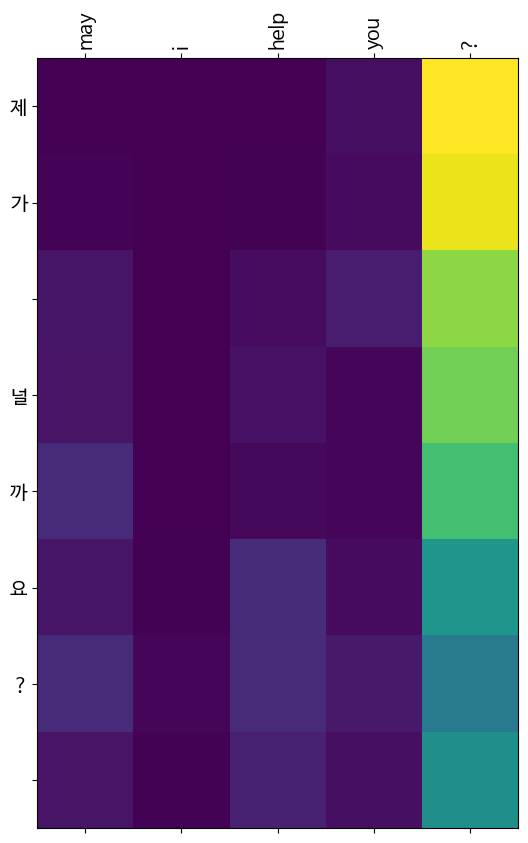

In [82]:
translate("May I help you?", model, encoder_tokenizer, decoder_tokenizer, max_len=40)

Input: can i have some coffee ?
Predicted translation: ['커피', '를', '조금', '', '드릴', '까', '요', '?', '']
Attention map saved to /content/work/dataset/kor-eng/attention_map_1.png


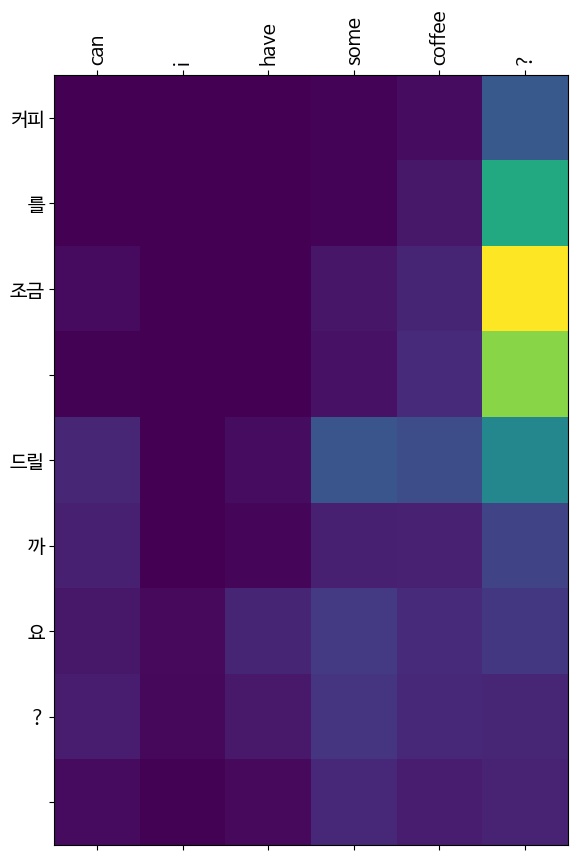

In [83]:
# 실행 예제
translate("Can I have some coffee?", model, encoder_tokenizer, decoder_tokenizer, max_len=40)

In [53]:
# 메모리 정리는 언제나 중요하다.
torch.cuda.empty_cache()